In [ ]:
#references
'''
1. https://scipy.github.io/devdocs/generated/scipy.spatial.voronoi_plot_2d.html 
2. https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/
3. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
'''

In [60]:
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

def rmse(y1,y2):
    return ((sum((y1-y2)**2))/len(y1))**0.5

In [61]:
filname='Real estate valuation data set.xlsx'
df=pd.read_excel(filname)
df[:10]

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
5,6,2012.666667,7.1,2175.03000,3,24.96305,121.51254,32.1
6,7,2012.666667,34.5,623.47310,7,24.97933,121.53642,40.3
7,8,2013.416667,20.3,287.60250,6,24.98042,121.54228,46.7
8,9,2013.500000,31.7,5512.03800,1,24.95095,121.48458,18.8
9,10,2013.416667,17.9,1783.18000,3,24.96731,121.51486,22.1


As is visible the features are not in same scale.

In [62]:
X=np.array(df)[:,:-1]
y=np.array(df)[:,-1]

In [63]:
X.shape

(414, 7)

In [64]:
y.shape

(414,)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

## 2a) K-Fold Cross Validation

In [66]:
def K_fold_cv( X, y, param_list=0, cv=5):
    kf=KFold(n_splits=cv)
    K_val=list(range(1,25,2))
    K_Opt=[]
    train_errors=[]
    test_errors=[]
    valdn_errors=[]
    for train_index, test_index in kf.split(X,y):
        X_train=X[train_index]
        y_train=y[train_index]
        X_test=X[test_index]
        y_test=y[test_index]
        
        mean_errors=[]  #to store mean error for each k for each fold to get the opt k
        for k in K_val:
            knn=KNN(n_neighbors=k)
            error=0
            for tri, tsi in kf.split(X_train, y_train):
                X_train__=X_train[tri]
                y_train__=y_train[tri]
                X_vald=X_train[tsi]
                y_vald=y_train[tsi]
                knn.fit(X_train__, y_train__)
                y_pred=knn.predict(X_vald)
                error+=rmse(y_pred, y_vald)
            mean_errors.append(error/cv)
        k_opt=K_val[mean_errors.index(min(mean_errors))]
        #print(mean_errors)
        K_Opt.append(k_opt)
        knn_=KNN(n_neighbors=k_opt)
        knn_.fit(X_train, y_train)
        
        train_errors.append(rmse(knn_.predict(X_train),y_train))
        test_errors.append(rmse(knn_.predict(X_test),y_test))
        valdn_errors.append(min(mean_errors))
    return [K_Opt, train_errors, test_errors, valdn_errors]

In [67]:
[K_Opt, train_errors, test_errors, valdn_errors] = K_fold_cv(X, y,1, cv=5)

In [68]:
print("The optimum values of K as found for each fold: ",K_Opt)

The optimum values of K as found for each fold:  [17, 17, 17, 23, 23]


In [69]:
np.array(train_errors)

array([8.88480694, 8.53453539, 8.48922001, 7.77691774, 8.82067931])

In [70]:
np.array(test_errors)

array([ 7.65593063,  9.36352325,  8.43829182, 11.56886259,  7.46480378])

In [85]:
np.array(valdn_errors)

array([9.27812015, 8.64326735, 9.35308464, 8.32382085, 9.1629077 ])

## 2b) KNN with Scaling the features in range [0,1]

In [72]:
[X.shape, y.shape]   #verifying that X, y correspond to the total data

[(414, 7), (414,)]

In [73]:
#scaling the data in range(0,1)
X_=np.copy(X)
for i in range(len(X_[0])):
    X_[:,i,]=X_[:,i]/max(X_[:,i])
[K_Opt, train_errors, test_errors, valdn_errors] = K_fold_cv(X_, y, cv=5)

In [74]:
print("The optimum values of K as found for each fold: ",K_Opt)

The optimum values of K as found for each fold:  [9, 7, 9, 13, 13]


In [75]:
np.array(train_errors)

array([8.87468566, 8.15374296, 8.75181304, 7.66924052, 8.84799661])

In [76]:
np.array(test_errors)

array([ 7.30832029,  9.88708192,  8.2894876 , 12.32612287,  7.78503714])

In [77]:
np.array(valdn_errors)

array([9.27812015, 8.64326735, 9.35308464, 8.32382085, 9.1629077 ])

As  visible, scaling the data to [0,1] reduces the K_opt value but the rmse values remain almost same

## 2(C)

In [78]:
X_train_=X[:int(0.8*len(X))]
X_test_=X[int(0.8*len(X)):]
y_train_=y[:int(0.8*len(y))]
ground_truth_=y[int(0.8*len(y)):]
for i in [X_train_,X_test_,y_train_,ground_truth_]:
    print(i.shape)

(331, 7)
(83, 7)
(331,)
(83,)


In [79]:
train_error=[]
test_error=[]
K=range(1,50,2)
for k in K:
    knn = KNN(n_neighbors=k)
    knn.fit(X_train_, y_train_)
    y=knn.predict(X_test_)
    y_=knn.predict(X_train_)
    train_error.append(rmse(y_,y_train_))
    test_error.append(rmse(y,ground_truth_))

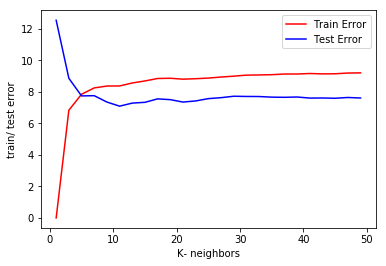

In [80]:
plt.plot(K,train_error,'r', label='Train Error')
plt.plot(K, test_error, 'b', label='Test Error')
plt.xlabel("K- neighbors")
plt.ylabel("train/ test error")
plt.legend()
plt.show()

The train error increases with increasing value of K, as in case of regression, the predicted value is the mean of the classes of K nearest values. Hence the no. of classes being considered increases and hence the effect of outliers increases which increase the error

## House with maximum RMSE error for K = 5

In [84]:
knn=KNN(n_neighbors=5)
knn.fit(X_train_, y_train_)
y_pred=knn.predict(X_test_)
rse=(y_pred-ground_trouth_)**2
idx=list(rse).index(max(rse))
print("The house with maximum RMSE in test set: House No. ", idx+1, "RMSE= ", max(rse)**0.5)
print("The house features: ", list(X_test_[idx]))

The house with maximum RMSE in test set: House No.  25 RMSE=  21.5
The house features:  [356.0, 2013.25, 3.8, 383.8624, 5.0, 24.98085, 121.54391]


In [82]:
df[100:110]

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
100,101,2013.500000,17.5,964.7496,4,24.98872,121.53411,38.2
101,102,2012.833333,12.7,170.1289,1,24.97371,121.52984,32.9
102,103,2013.083333,1.1,193.5845,6,24.96571,121.54089,54.4
103,104,2012.750000,0.0,208.3905,6,24.95618,121.53844,45.7
104,105,2012.666667,32.7,392.4459,6,24.96398,121.54250,30.5
105,106,2012.833333,0.0,292.9978,6,24.97744,121.54458,71.0
106,107,2013.083333,17.2,189.5181,8,24.97707,121.54308,47.1
107,108,2013.333333,12.2,1360.1390,1,24.95204,121.54842,26.6
108,109,2013.416667,31.4,592.5006,2,24.97260,121.53561,34.1
109,110,2013.583333,4.0,2147.3760,3,24.96299,121.51284,28.4


The error is probably due to the high difference in the values of house age which makes it an outlier. It can be reduced by varying the value of K or taking a subset of meaningful features or by scaling the data in the range [0,1]